### Using to test deployment of rare species (largest classes) to report main latency measurements on

In this notebook we generate a sample [pareto frontier](https://en.wikipedia.org/wiki/Pareto_front) plot of accuracy/latency tradeoff for the Rare species dataset (with 400 classes).

For this notebook, a dataframe of mobilevit modified with various adapter options is already provided. In a later step, you will train sample of these models and query the weights and biases API to generate model configuration and corresponding accuracy for a given dataset.

In [12]:
# !pip install seaborn adjustText

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../utilities')
from wandb_run_best import OptunaSubmodelAnalyzer

In [ ]:
# the code below queries an old set of experiments that you don't have access to but once you train some new models, you can use similar code 
# to query the wandb API

In [47]:
# filters = {
#     "tags": {"$in": ["mvit_last_two_adpt__dsentplt"]}, # "eformer_last_two_adpt__dsentplt"
#     "config.dataset": {"$in": ["rare_species"]},
#     "config.model": {"$in": ["mobilevit"]}
#     # "state": "finished"
# }

# # submodel_keys = ["dataset", "model", "B5_adapters", "B6_adapters", "adapter_type", "chain_type"]
# submodel_keys = ["chain_type", "adapter_type", "input_dependent_gating"] # "reduction",
# extra_fields = [
#     "B5_adapters", "B6_adapters", "dataset", "model"
#     # "trial_number",      # if using optuna
# ]

# analyzer = OptunaSubmodelAnalyzer(
#     project_path="multimodal-env/mobilevit-adapter-ablation",
#     filters=filters,
#     submodel_keys=submodel_keys,
#     eval_key="val_acc",
#     extra_fields=extra_fields
# )

# print("created analyzer")
# df_all = analyzer.load_dataframe()
# print("finding topk best models")
# top3_runs_per_submodel = analyzer.get_topk_per_submodel(k=3)
# top3_submodels = analyzer.get_topk_submodels(k=3)

# top3_runs_per_submodel.to_csv('./sample_top_3_performing_submodels_per_config.csv')

# print(df_all)
# print(top3_runs_per_submodel)
# print(top3_submodels)

In [6]:
# load the pre-generated CSV of model configurations and corresponding accuracies on rare_species dataset
import pandas as pd
top3_runs_per_submodel = pd.read_csv('./sample_top_3_performing_submodels_per_config.csv')

In [18]:
top3_submodels.dataset.unique()

array(['rare_species'], dtype=object)

In [8]:
top3_runs_per_submodel.head()

,Unnamed: 0,run_id,val_acc,submodel_key,chain_type,adapter_type,input_dependent_gating,B5_adapters,B6_adapters,dataset,model
0,0,zjnedpqq,0.7175,"(('chain_type', 'seq'), ('adapter_type', 'simp...",seq,simple,True,1,8,rare_species,mobilevit
1,1,633mqtzi,0.7110,"(('chain_type', 'seq_input'), ('adapter_type',...",seq_input,simple,True,2,4,rare_species,mobilevit
2,2,k6xhdblt,0.7105,"(('chain_type', 'seq_input'), ('adapter_type',...",seq_input,simple,True,2,4,rare_species,mobilevit
3,3,snlouagi,0.7100,"(('chain_type', 'seq_input'), ('adapter_type',...",seq_input,bottleneck,True,2,4,rare_species,mobilevit
4,4,re3df193,0.7090,"(('chain_type', 'seq_input'), ('adapter_type',...",seq_input,simple,True,8,4,rare_species,mobilevit


In [35]:
mdl = adapter_model_from_row(top3_runs_per_submodel.iloc[0])
# fname = filename_from_row(top3_runs_per_submodel.iloc[0])

[INFO]: Using ChainSequential
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequential
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequential
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequential
[INFO]: Using conv adapter experts


In [33]:
import timm
from argparse import Namespace
from configs.adapter_config import AdapterConfig
from adapters.injector import inject_adapters_mvit, inject_adapters_eformer

def adapter_model_from_row(row):
    num_classes_map = {'birds_inat': 60, 'rare_species': 400, 'iwildcam': 182}
    args = Namespace()
    args.adapter_type = row.adapter_type
    args.deploy = True
    
    num_classes = num_classes_map[row.dataset]
    adapter_cfg = AdapterConfig(
            place_on="mlp",
            layer_mode="every",
            every=2
        )

    if "mobilevit" in row.model.lower():
        model = timm.create_model('mobilevitv2_050.cvnets_in1k', pretrained=True, num_classes=num_classes)
        model = inject_adapters_mvit(model, chain_type=row.chain_type, config=adapter_cfg,
                                               experts=(row.B5_adapters, row.B6_adapters), args=args)
    elif "efficientformer" in row.model.lower():
        model = timm.create_model('efficientformerv2_s0', pretrained=True, num_classes=num_classes)
        # print('chain_cls', chain_cls)
        model = inject_adapters_after_ffn_eformer(model, chain_type=row.chain_type, config=adapter_cfg,
                                                  experts=(row.B5_adapters, row.B6_adapters), args=args)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    return model

def filename_from_row(row):
    # backbone_B5_B6_{type}
    chain_map = {"seq": "S", "par_fixed": "P", "seq_input": "SI", "par_input": "PI"}
    name = "MViT" if "mobilevit" in row.model else "Eformer"
    if row.B5_adapters > 0:
        name += f"_{row.B5_adapters}B5"
    if row.B6_adapters > 0:
        name += f"_{row.B6_adapters}B6"
    chain_name = chain_map[row.chain_type]
    name += f"_{chain_name}"
    return name

In [29]:
filename_from_row(top3_runs_per_submodel.iloc[0])

'MViT_1B5_8B6_S'

In [ ]:
# Create the deployment files for iOS to measure latency. For now, we will record the latency values in the next cell
# using the dictionary named `ADAPTER_LATENCIES`. In the future, we will save such dictionaries in json files for reuse.

In [36]:
import timm
import os
import torch
import coremltools as ct

dsname = 'rare_species'
save_dir = f"outputs_ane_deploy_{dsname}_0"
os.makedirs(save_dir, exist_ok=True)


# for name, cls in variants.items():
for idx, row in top3_runs_per_submodel.iterrows():

    model = adapter_model_from_row(row)
    fname = filename_from_row(row)
    
    # Dummy input
    x = torch.randn(1, 3, 224, 224)

    with torch.no_grad():
        y = model(x)
    # print(f"Wrapped output shape last2={last2}, last1={last1}: {y.shape}")
    
    print(f"{fname} output shape: {y.shape}")

    # Trace and convert
    traced = torch.jit.trace(model, x)
    mlmodel = ct.convert(
        traced,
        source="pytorch",
        inputs=[ct.TensorType(name="x", shape=x.shape)],
        # outputs=[ct.TensorType(name="out")],
        compute_units=ct.ComputeUnit.ALL,  # Use ANE, GPU, CPU as fallback
        minimum_deployment_target=ct.target.iOS14  # ← key change 
    )
    mlmodel.save(os.path.join(save_dir, f"{fname}_test.mlmodel"))

print(f"All MLModels saved in {save_dir}")

[INFO]: Using ChainSequential
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequential
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequential
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequential
[INFO]: Using conv adapter experts
MViT_1B5_8B6_S output shape: torch.Size([1, 400])


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/timm/models/mobilevit.py:508: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  new_h, new_w = math.ceil(H / patch_h) * patch_h, math.ceil(W / patch_w) * patch_w
/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/timm/models/mobilevit.py:511: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if new_h != H or new_w != W:
Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Running MIL default pipeline:  10%|█████████████                                 

[INFO]: Using ChainSequentialInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequentialInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequentialInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequentialInputDependent
[INFO]: Using conv adapter experts
MViT_2B5_4B6_SI output shape: torch.Size([1, 400])


Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Running MIL default pipeline:  10%|█████████████                                                                                                                        | 9/92 [00:00<00:02, 40.67 passes/s]/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '1509', of the source model, has been renamed to 'var_1509' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1934/1934 [00:00<00:00, 7001.29 ops/s]


[INFO]: Using ChainSequentialInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequentialInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequentialInputDependent
[INFO]: Using conv adapter experts
[INFO]: Using ChainSequentialInputDependent
[INFO]: Using conv adapter experts
MViT_2B5_4B6_SI output shape: torch.Size([1, 400])


Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Translating MIL ==> NeuralNetwork Ops: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1934/1934 [00:00<00:00, 6938.31 ops/s]


[INFO]: Using ChainSequentialInputDependent
[INFO]: Using bottleneck adapter experts


AttributeError: 'Namespace' object has no attribute 'reduction'

In [71]:
import timm
import os
import torch
import coremltools as ct

dsname = 'rare_species'
save_dir = f"outputs_ane_deploy_{dsname}_0"
os.makedirs(save_dir, exist_ok=True)


# for name, cls in variants.items():
for idx, row in top3_runs_per_submodel.iterrows():

    model = adapter_model_from_row(row)
    fname = filename_from_row(row)
    
    # Dummy input
    x = torch.randn(1, 3, 224, 224)

    with torch.no_grad():
        y = model(x)
    # print(f"Wrapped output shape last2={last2}, last1={last1}: {y.shape}")
    
    print(f"{fname} output shape: {y.shape}")

    # Trace and convert
    traced = torch.jit.trace(model, x)
    mlmodel = ct.convert(
        traced,
        source="pytorch",
        inputs=[ct.TensorType(name="x", shape=x.shape)],
        # outputs=[ct.TensorType(name="out")],
        compute_units=ct.ComputeUnit.ALL,  # Use ANE, GPU, CPU as fallback
        minimum_deployment_target=ct.target.iOS14  # ← key change 
    )
    mlmodel.save(os.path.join(save_dir, f"{fname}_test.mlmodel"))

print(f"All MLModels saved in {save_dir}")

MViT_1B5_8B6_S output shape: torch.Size([1, 400])


/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/timm/models/mobilevit.py:536: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  new_h, new_w = math.ceil(H / patch_h) * patch_h, math.ceil(W / patch_w) * patch_w
/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/timm/models/mobilevit.py:539: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if new_h != H or new_w != W:
Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Running MIL default pipeline:  10%|█████████████                                 

MViT_2B5_4B6_SI output shape: torch.Size([1, 400])


Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Running MIL default pipeline:  10%|█████████████                                                                                                                        | 9/92 [00:00<00:01, 41.54 passes/s]/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '1505', of the source model, has been renamed to 'var_1505' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1930/1930 [00:00<00:00, 7130.71 ops/s]


MViT_2B5_4B6_SI output shape: torch.Size([1, 400])


Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Translating MIL ==> NeuralNetwork Ops: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1930/1930 [00:00<00:00, 7105.50 ops/s]


MViT_2B5_4B6_SI output shape: torch.Size([1, 400])


Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Translating MIL ==> NeuralNetwork Ops: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1930/1930 [00:00<00:00, 7231.00 ops/s]


MViT_8B5_4B6_SI output shape: torch.Size([1, 400])


Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Running MIL default pipeline:   9%|███████████▌                                                                                                                         | 8/92 [00:00<00:02, 33.20 passes/s]/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '1830', of the source model, has been renamed to 'var_1830' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2278/2278 [00:00<00:00, 7784.44 ops/s]


MViT_8B5_4B6_S output shape: torch.Size([1, 400])


Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Running MIL default pipeline:   9%|███████████▌                                                                                                                         | 8/92 [00:00<00:02, 34.44 passes/s]/gscratch/scrubbed/emazuh/hyvitav2/lib/python3.10/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:273: UserWarning: Output, '1725', of the source model, has been renamed to 'var_1725' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2070/2070 [00:00<00:00, 7157.07 ops/s]


All MLModels saved in outputs_ane_deploy_rare_species_0


In [72]:
# !zip -r test_ane_rare_0.zip outputs_ane_deploy_rare_species_0/

  adding: outputs_ane_deploy_rare_species_0/ (stored 0%)
  adding: outputs_ane_deploy_rare_species_0/MViT_8B5_4B6_SI_test.mlmodel (deflated 8%)
  adding: outputs_ane_deploy_rare_species_0/MViT_1B5_8B6_S_test.mlmodel (deflated 8%)
  adding: outputs_ane_deploy_rare_species_0/MViT_2B5_4B6_SI_test.mlmodel (deflated 8%)
  adding: outputs_ane_deploy_rare_species_0/MViT_8B5_4B6_S_test.mlmodel (deflated 8%)


In [38]:
ADAPTER_LATENCIES = {
  "metadata": {
    "device": "iPhone 13",
    "backend": "ANE",
    "ios_version": "18.0",
    "batch_size": 1,
    "naming_convention": "",
    "notes": "ran on maco Sequoia 15.5 Memory 16G Apple M1 Xcode"
  },
  "top_candidates": {
    "MViT_8B5_4B6_SI": {
      "description": "",
      "trained_modules": "",
      "latency": 2.59,
      "ANE_Op_Count": 1012,
      "second_run_latency_median": 2.52,
      "third_run_latency_median": 2.48,
    },
    "MViT_1B5_8B6_S": {
      "description": "",
      "trained_modules": "",
      "latency": 2.71,
      "ANE_Op_Count": 852,
      "second_run_latency_median": 2.42,
      "third_run_latency_median": 2.35,
    },
    "MViT_2B5_4B6_SI": {
      "description": "",
      "trained_modules": "",
      "latency": 2.40,
      "ANE_Op_Count": 832,
      "second_run_latency_median": 2.30,
      "third_run_latency_median": 2.42,
    },
    "MViT_8B5_4B6_S": {
      "description": "",
      "trained_modules": "",
      "latency": 2.45,
      "ANE_Op_Count": 924,
      "second_run_latency_median": 2.47,
      "third_run_latency_median": 2.21,
    },
  },
}

In [39]:
import pandas as pd
adapter_latencies_mvit = pd.DataFrame(ADAPTER_LATENCIES["top_candidates"]).T

In [40]:
adapter_latencies_mvit['model_cfg'] = adapter_latencies_mvit.index
top3_runs_per_submodel['model_cfg'] = top3_runs_per_submodel.apply(filename_from_row, axis=1)

In [41]:
adapter_latencies_mvit

,description,trained_modules,latency,ANE_Op_Count,second_run_latency_median,third_run_latency_median,model_cfg
MViT_8B5_4B6_SI,,,2.59,1012,2.52,2.48,MViT_8B5_4B6_SI
MViT_1B5_8B6_S,,,2.71,852,2.42,2.35,MViT_1B5_8B6_S
MViT_2B5_4B6_SI,,,2.4,832,2.3,2.42,MViT_2B5_4B6_SI
MViT_8B5_4B6_S,,,2.45,924,2.47,2.21,MViT_8B5_4B6_S


In [43]:
frontier_df = pd.merge(top3_runs_per_submodel[['model_cfg', 'val_acc']], adapter_latencies_mvit[['model_cfg', 'third_run_latency_median']], 
                       left_on='model_cfg', right_on='model_cfg', how='outer')
frontier_df["accuracy"] = frontier_df['val_acc'].astype(float)
frontier_df["latency"] = frontier_df['third_run_latency_median'].astype(float)
frontier_df['config'] = frontier_df['model_cfg'].map(lambda x: '_'.join(x.split('_')[1:]))
frontier_df['model_name'] = frontier_df['model_cfg'].map(lambda x: x.split('_')[0])
frontier_df.fillna(0, inplace=True)
frontier_df.head()

,model_cfg,val_acc,third_run_latency_median,accuracy,latency,config,model_name
0,MViT_1B5_8B6_S,0.7175,2.35,0.7175,2.35,1B5_8B6_S,MViT
1,MViT_2B5_4B6_SI,0.7110,2.42,0.7110,2.42,2B5_4B6_SI,MViT
2,MViT_2B5_4B6_SI,0.7105,2.42,0.7105,2.42,2B5_4B6_SI,MViT
3,MViT_2B5_4B6_SI,0.7100,2.42,0.7100,2.42,2B5_4B6_SI,MViT
4,MViT_8B5_4B6_S,0.7030,2.21,0.7030,2.21,8B5_4B6_S,MViT


In [45]:
adapter_latencies_mvit

,description,trained_modules,latency,ANE_Op_Count,second_run_latency_median,third_run_latency_median,model_cfg
MViT_8B5_4B6_SI,,,2.59,1012,2.52,2.48,MViT_8B5_4B6_SI
MViT_1B5_8B6_S,,,2.71,852,2.42,2.35,MViT_1B5_8B6_S
MViT_2B5_4B6_SI,,,2.4,832,2.3,2.42,MViT_2B5_4B6_SI
MViT_8B5_4B6_S,,,2.45,924,2.47,2.21,MViT_8B5_4B6_S


In [48]:
from measurement_utils.plotting_utils import plot_pareto_frontier

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


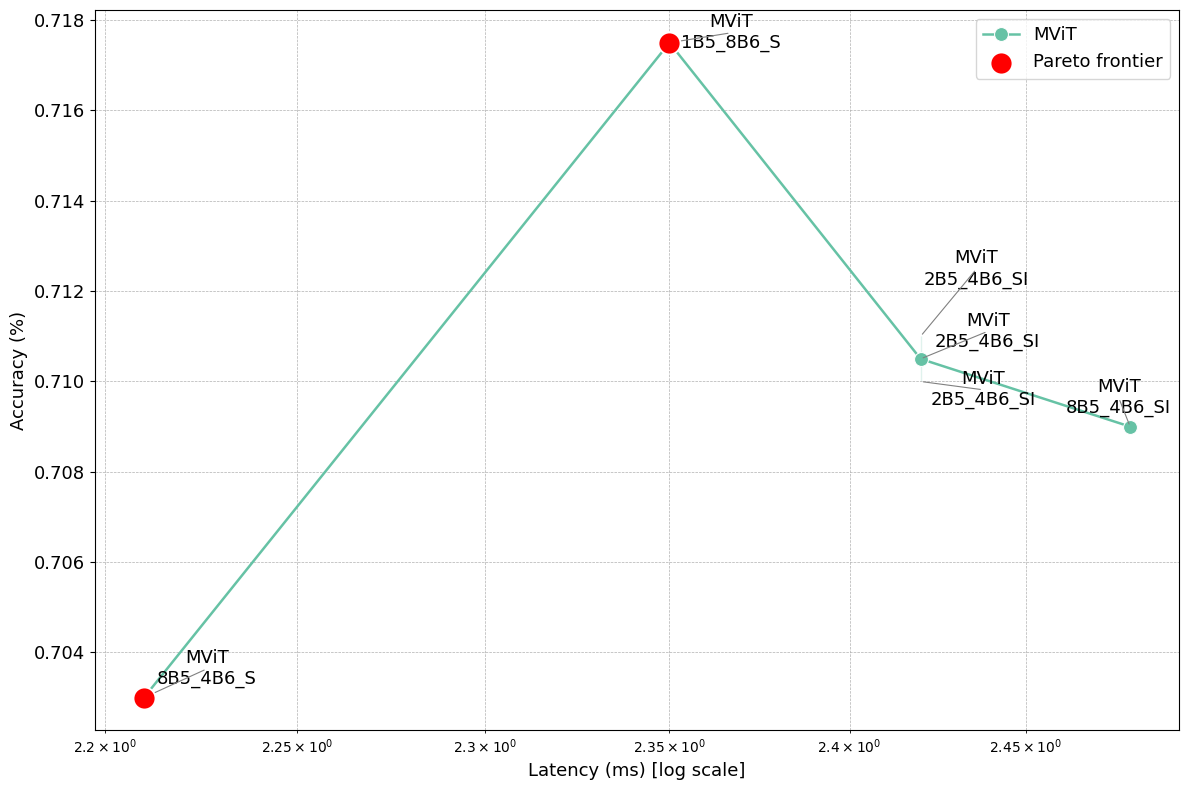

In [49]:
plot_pareto_frontier(frontier_df[['model_name', 'config', 'latency', 'accuracy']], font_size=13, add_title=False,
                     save_loc=f'./rare_species_p25_mvit_pareto.pdf')